# Inverse Correlated LETF Pair Trading

The Leveraged ETF pair provide higher return through leverage while lowering risk through inverse correlated pairs.

*References:* 

1. Gayed, Michael and Bilello, Charles, Leverage for the Long Run - A Systematic Approach to Managing Risk and Magnifying Returns in Stocks (March 3, 2016). 2016 Charles H. Dow Award, Available at SSRN: https://ssrn.com/abstract=2741701 or http://dx.doi.org/10.2139/ssrn.2741701

2. Andreas Clenow, Trading Evolved, 2019

**Trading Rule**

1. LETFs: TMF and TQQQ
    
2. Rebalancing period: Quarterly
    
3. Allocation based on inverse volatility. Volatility calculation: Maximum of Mean of Rolling 20 day standard deviation of daily percent change in price, over past 126 days OR Last 20 day standard deviation of daily percent change.

In [1]:
import zipline
from zipline.api import order_target_percent, symbol, schedule_function, date_rules, time_rules, set_benchmark, get_datetime

from datetime import datetime
import pytz

from matplotlib import pyplot as plt, ticker, rc
import pandas as pd
import numpy as np
from scipy import stats

import pyfolio as pf

In [2]:
"""
    Model Settings
"""
INIT_PORTFOLIO = 10000
VOLA_WINDOW = 20
LOOKBACK_WINDOW = 126
QUARTER_STARTS = [2, 5, 8, 11]

def volatility(ts):
    std1 = ts.pct_change().dropna().rolling(VOLA_WINDOW).std().mean()
    std2 = ts.pct_change().dropna().rolling(VOLA_WINDOW).std().iloc[-1]

    return max(std1, std2)

def output_progress(context):
    """
        Output some performance numbers during backtest
    """
    # get today's date
    today = zipline.api.get_datetime().date()
    
    # calculate percent diff since last month
    perf_pct = (context.portfolio.portfolio_value / context.last_month) - 1
    
    # Print performance
    print("{} - Last Month Result: {:.2%}.".format(today, perf_pct))

    # Remember today's portfolio value for next month calc
    context.last_month = context.portfolio.portfolio_value
    
    # Print new allocation every quarter
#    if get_datetime().date().month in [x + 1 for x in QUARTER_STARTS]:
#        t = ""
#        for key, value in context.new_weight.items():
#            t += "{}: {:.2%} ".format(key, value)
#        print("{} - This Quarter New Allocation: {}.".format(today, t))
#        #print(context.new_weight)

In [3]:
def initialize(context):
    # Used only for progress report
#    context.last_month = INIT_PORTFOLIO
    # Used for history window
    context.vola_window = VOLA_WINDOW
    context.lookback_window = LOOKBACK_WINDOW
    
    # ETF
    etfs = ['TMF', 'TQQQ']
    context.etfs = [symbol(s) for s in etfs]
    
    set_benchmark(False)
    
    # Schedule rebalance for once a quarter
    schedule_function(rebalance, date_rules.month_start(), time_rules.market_open())

In [4]:
def rebalance(context, data):
    # Output progress
#    output_progress(context)
    
    # If the current month number is not in QUARTER_STARTS, don't do anything
    month_number = get_datetime().date().month
    if month_number not in QUARTER_STARTS:
        return
    
    # Otherwise execute rebalance
    # Get historical 126 day data for volatility calculation
    hist = data.history(context.etfs, "close", LOOKBACK_WINDOW, "1d")
    hist = hist.dropna()
    
    # Calculate inverse volatility for etfs and make target positions weights
    vola_table = hist[context.etfs].apply(volatility)
    inv_vola_table = 1 / vola_table
    sum_inv_vola = np.sum(inv_vola_table)
    vola_target_weights = inv_vola_table / sum_inv_vola
    
    # place order for targeted weights
    for etf in context.etfs:
        weight = vola_target_weights[etf]
        order_target_percent(etf, weight)

In [5]:
# set start and end date
start = pd.to_datetime('2010-03-10', utc=True)
end = pd.to_datetime('2020-08-31', utc=True)

# start backtest
result = zipline.run_algorithm(
    start = start, 
    end = end, 
    initialize = initialize, 
    capital_base = INIT_PORTFOLIO, 
    data_frequency = 'daily', 
    bundle = 'etf_db_data')

/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/empyrical/stats.py:711: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Entire data start date: 2010-03-10
Entire data end date: 2020-08-31


Backtest Months: 125


Performance statistics,Backtest
annual_return,0.38
annual_volatility,0.27
sharpe_ratio,1.34
calmar_ratio,0.90
stability_of_timeseries,0.99
max_drawdown,-0.42
omega_ratio,1.26
sortino_ratio,1.91
skew,-0.59
kurtosis,6.60


/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/pyfolio/timeseries.py:416: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  beta, alpha = sp.stats.linregress(factor_returns.loc[ret_index].values,
/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,42.06,2020-03-06,2020-03-18,2020-06-10,69
1,23.92,2016-09-06,2016-12-01,2017-04-18,161
2,23.11,2018-08-30,2018-11-02,2019-03-21,146
3,21.17,2013-05-02,2013-06-25,2013-10-18,122
4,20.83,2015-04-24,2015-08-25,2016-03-29,243




[-0.032 -0.067]


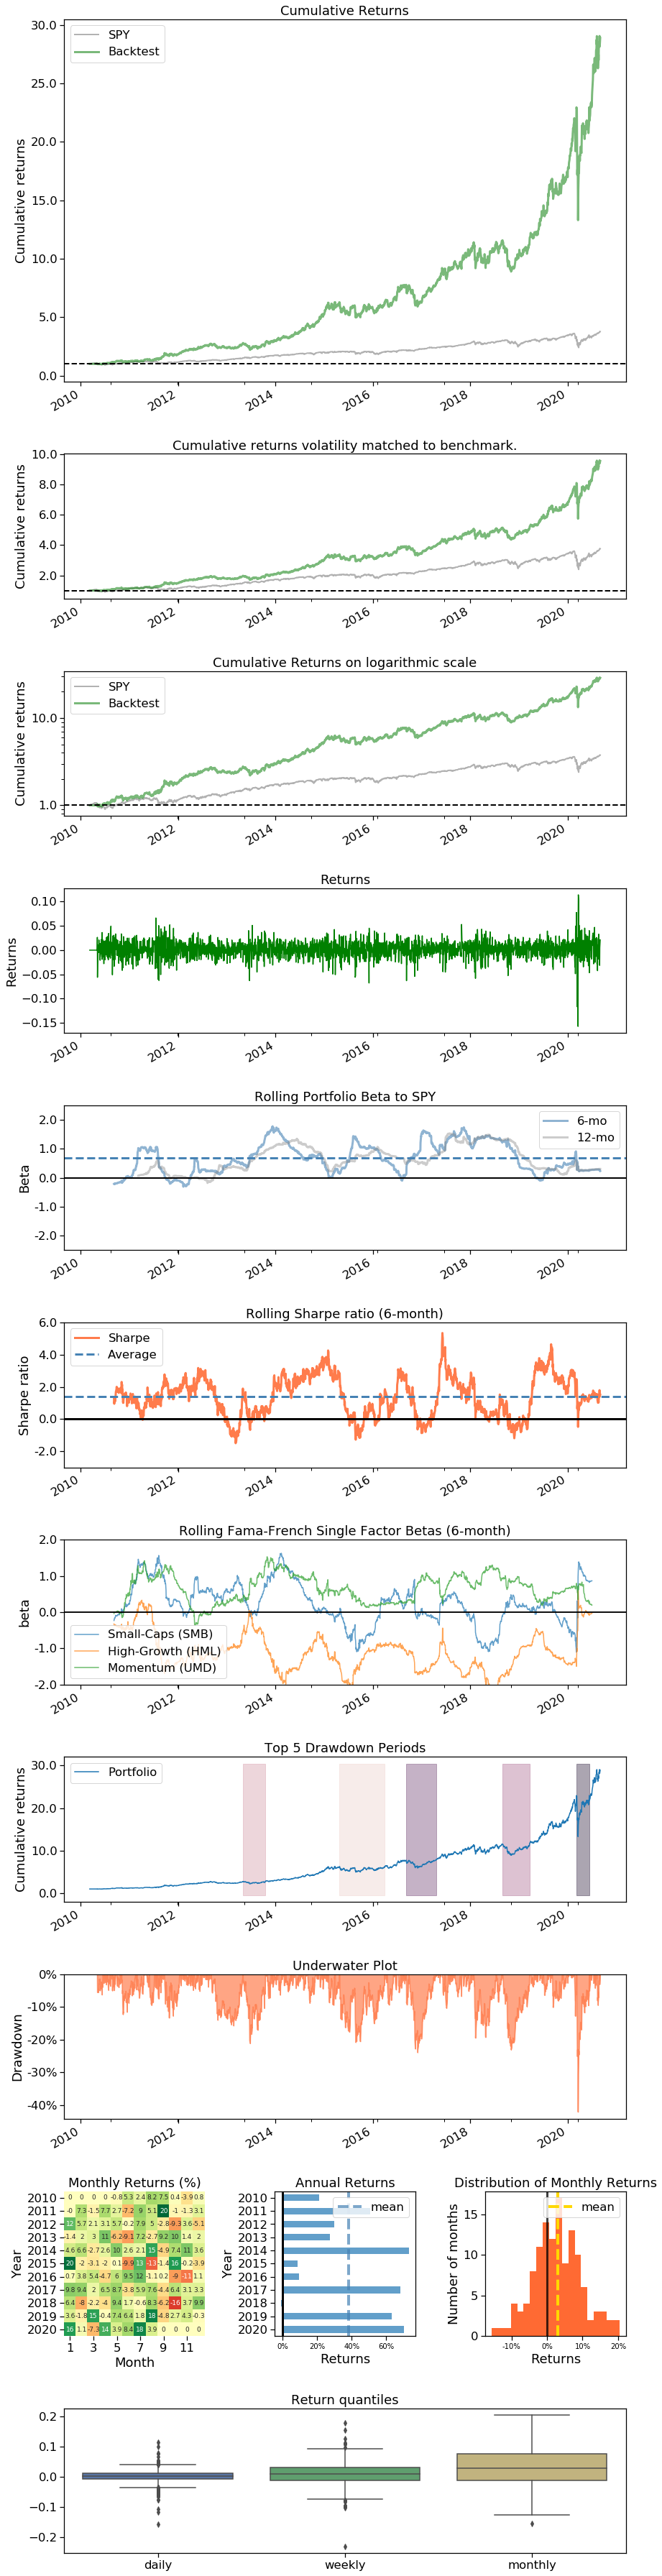

Stress Events,mean,min,max
US downgrade/European Debt Crisis,0.41%,-6.25%,5.06%
Fukushima,0.13%,-2.07%,2.09%
EZB IR Event,-0.30%,-3.06%,1.61%
Flash Crash,-0.50%,-5.60%,2.64%
Apr14,0.22%,-2.33%,2.08%
Oct14,0.32%,-2.90%,2.50%
Fall2015,-0.43%,-5.59%,3.90%
Recovery,0.13%,-6.25%,6.64%
New Normal,0.14%,-15.72%,11.41%


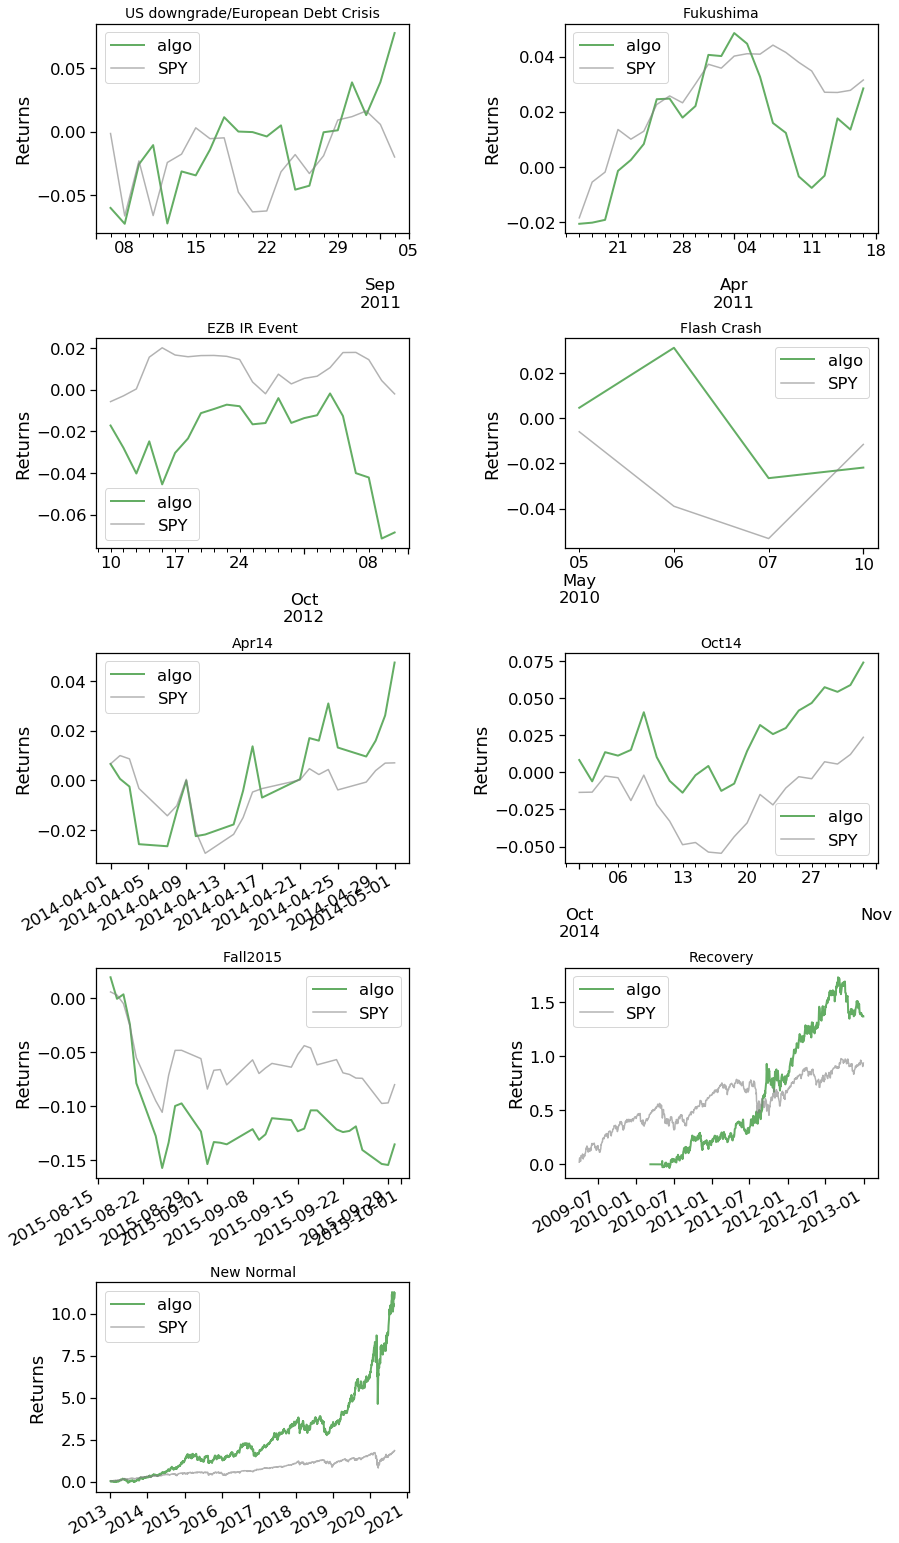

Top 10 long positions of all time,max
Equity(200 [TMF]),90.04%
Equity(204 [TQQQ]),63.26%


Top 10 short positions of all time,max


Top 10 positions of all time,max
Equity(200 [TMF]),90.04%
Equity(204 [TQQQ]),63.26%


All positions ever held,max
Equity(200 [TMF]),90.04%
Equity(204 [TQQQ]),63.26%


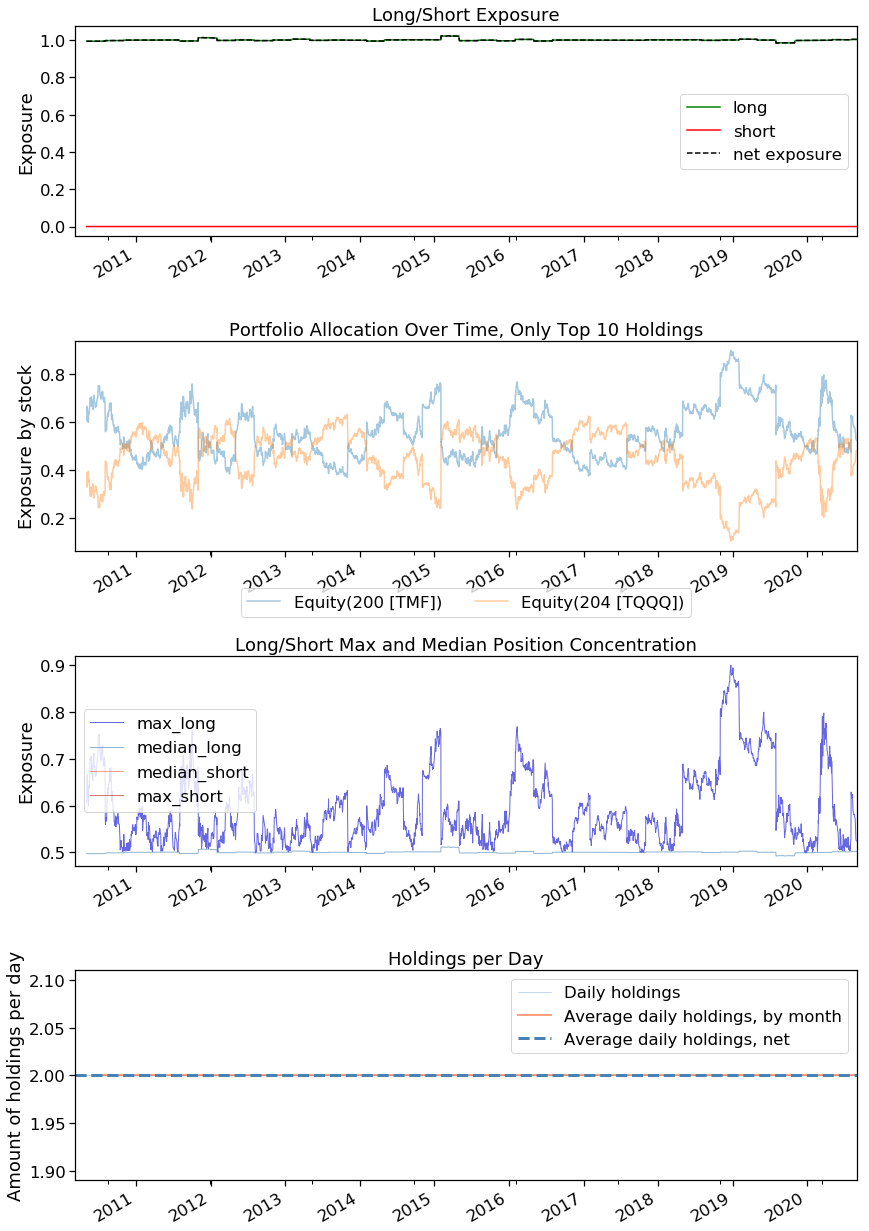

/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/pyfolio/plotting.py:1210: FutureWarning: 
.resample() is now a deferred operation
You called plot(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  **kwargs)


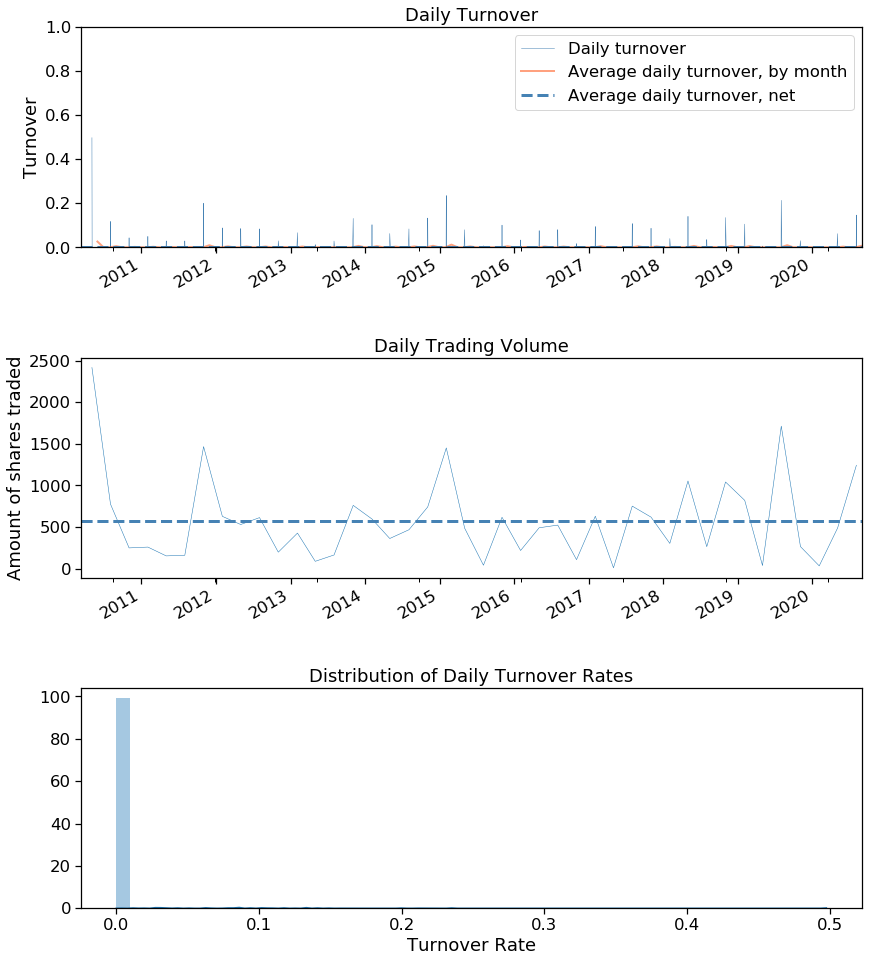

/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/pyfolio/round_trips.py:73: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/pyfolio/round_trips.py:76: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  axis='columns'))
/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/pyfolio/round_trips.py:79: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/pyfolio/round_trips.py:83: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  axis='columns'))
/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/pyfolio/round_trips.py:372: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  round

Summary stats,All trades,Long trades
Total number of round_trips,43.00,43.00
Percent profitable,1.00,1.00
Winning round_trips,43.00,43.00
Losing round_trips,0.00,0.00
Even round_trips,0.00,0.00


PnL stats,All trades,Long trades
Total profit,$279030.57,$279030.57
Gross profit,$279030.57,$279030.57
Gross loss,$0.00,$0.00
Profit factor,$nan,$nan
Avg. trade net profit,$6489.08,$6489.08
Avg. winning trade,$6489.08,$6489.08
Avg. losing trade,$nan,$nan
Ratio Avg. Win:Avg. Loss,$nan,$nan
Largest winning trade,$87003.42,$87003.42
Largest losing trade,$67.11,$67.11


Duration stats,All trades,Long trades
Avg duration,1018 days 05:01:23.767441,1018 days 05:01:23.767441
Median duration,1094 days 00:00:00,1094 days 00:00:00
Avg # round_trips per day,0.02,0.02
Avg # round_trips per month,0.49,0.49


Return stats,All trades,Long trades
Avg returns all round_trips,4.29%,4.29%
Avg returns winning,4.29%,4.29%
Avg returns losing,nan%,nan%
Median returns all round_trips,3.45%,3.45%
Median returns winning,3.45%,3.45%
Median returns losing,nan%,nan%
Largest winning trade,11.90%,11.90%
Largest losing trade,0.08%,0.08%


Symbol stats,Equity(200 [TMF]),Equity(204 [TQQQ])
Avg returns all round_trips,4.74%,4.12%
Avg returns winning,4.74%,4.12%
Avg returns losing,nan%,nan%
Median returns all round_trips,3.95%,3.14%
Median returns winning,3.95%,3.14%
Median returns losing,nan%,nan%
Largest winning trade,10.65%,11.90%
Largest losing trade,0.80%,0.08%


Profitability (PnL / PnL total) per name,pnl
symbol,
Equity(204 [TQQQ]),0.67%
Equity(200 [TMF]),0.33%


/opt/anaconda3/envs/zip35b/lib/python3.5/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: Axis limits cannot be NaN or Inf

<Figure size 1008x1296 with 0 Axes>

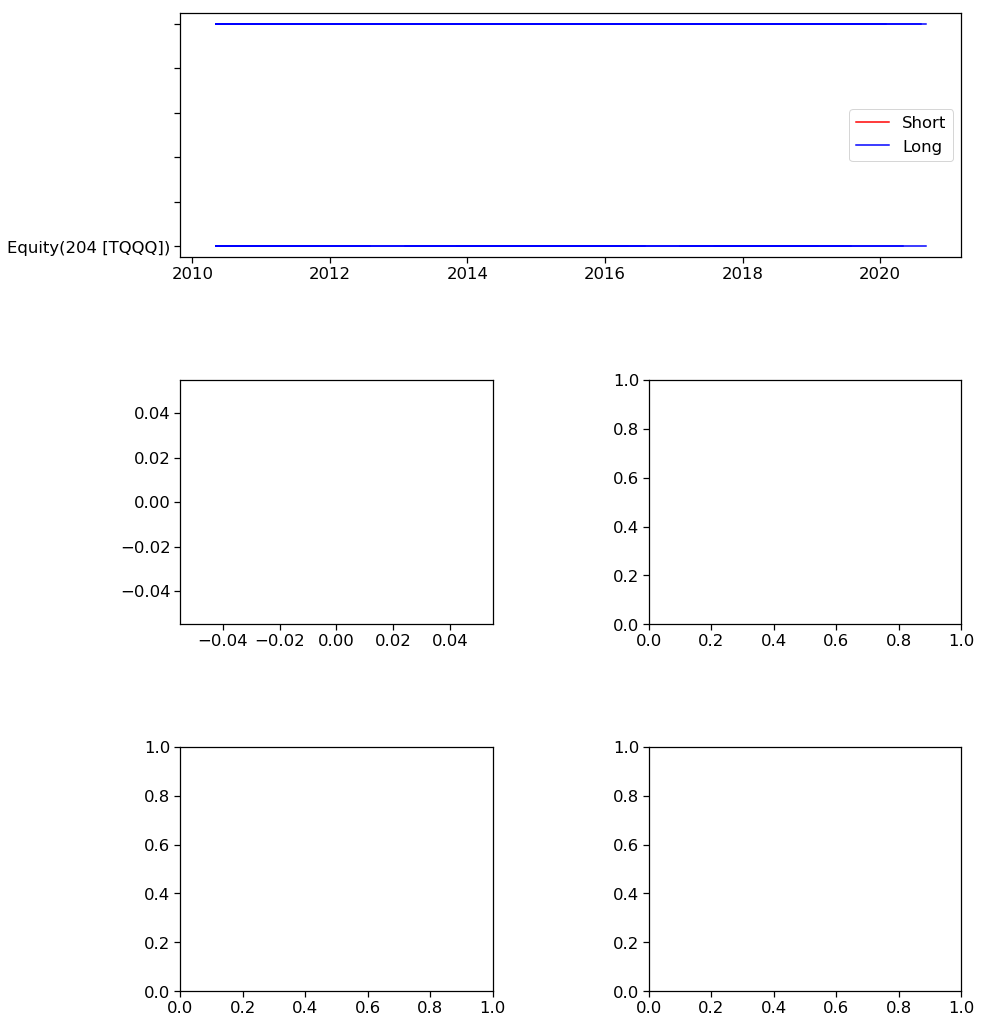

In [6]:
# Performance Analysis - Pyfolio Returns Tear Sheet
returns, positions, transactions, leverage = pf.utils.extract_rets_pos_txn_from_zipline(result)
pf.create_full_tear_sheet(returns, positions = positions, transactions = transactions, round_trips = True)

KeyError: 'returns'

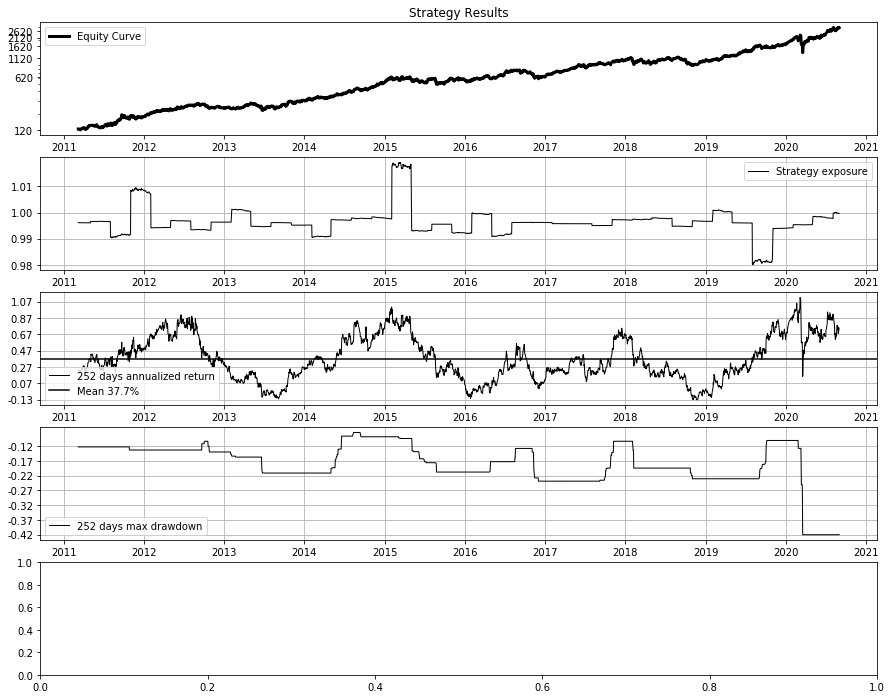

In [7]:
# Settings
window = 252
year_length = 252

# Copy the columns we need
df = result.copy().filter(items=['portfolio_value', 'gross_leverage'])

# Function for annualized return
def ann_ret(ts):
    return np.power((ts[-1] / ts[0]), (year_length/len(ts))) -1  

# Function for drawdown
def dd(ts):
    return np.min(ts / np.maximum.accumulate(ts)) - 1

# Get a rolling window
rolling_window = result.portfolio_value.rolling(window)

# Calculate rolling analytics
df['annualized'] = rolling_window.apply(ann_ret)
df['drawdown'] = rolling_window.apply(dd)

# Drop initial n/a values
df.dropna(inplace=True)

# Make a figure
fig = plt.figure(figsize=(15, 12))

# Make the base lower, just to make the graph easier to read
df['portfolio_value'] /= 100

# First chart
ax = fig.add_subplot(511)
ax.set_title('Strategy Results')
ax.plot(df['portfolio_value'], 
        linestyle='-', 
        color='black',
        label='Equity Curve', linewidth=3.0)

# Set log scale
ax.set_yscale('log') 

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['portfolio_value'].min(), df['portfolio_value'].max(), 500 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

# Add legend and grid
ax.legend()
ax.grid(False)

# Second chart
ax = fig.add_subplot(512)
ax.plot(df['gross_leverage'], 
        label='Strategy exposure'.format(window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['gross_leverage'].min(), df['gross_leverage'].max(), 0.01 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Third chart
ax = fig.add_subplot(513)
ax.plot(df['annualized'], 
        label='{} days annualized return'.format(window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)
ax.axhline(df['annualized'].mean(), color='black', linewidth=1.5, label='Mean {:0.1f}%'.format(df['annualized'].mean() * 100))

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['annualized'].min(), df['annualized'].max(), 0.2 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Fourth chart
ax = fig.add_subplot(514)
ax.plot(df['drawdown'], 
        label='{} days max drawdown'.format(window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['drawdown'].min(), df['drawdown'].max(), 0.05 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Fifth chart
ax = fig.add_subplot(515)
ax.plot(df['returns'], label = 'Daily Returns', linestyle='-.', linewidth = 1.0)
ax.legend()
ax.grid(True)

In [8]:
"""
    Monthly Time Return Table
"""


# Used for performance calculations
import empyrical as em

# Used for displaying HTML formatted content in notebook
from IPython.core.display import display, HTML

# Use Empyrical to aggregate on monthly and yearly periods
monthly_data = em.aggregate_returns(result['portfolio_value'].pct_change(), 'monthly')
yearly_data = em.aggregate_returns(result['portfolio_value'].pct_change(), 'yearly')

# Start off an HTML table for display
# HTML Table for display
table = """
<table class='table table-hover table-condensed table-striped'>
<thead>
<tr>
<th style="text-align:right">Year</th>
<th style="text-align:right">Jan</th>
<th style="text-align:right">Feb</th>
<th style="text-align:right">Mar</th>
<th style="text-align:right">Apr</th>
<th style="text-align:right">May</th>
<th style="text-align:right">Jun</th>
<th style="text-align:right">Jul</th>
<th style="text-align:right">Aug</th>
<th style="text-align:right">Sep</th>
<th style="text-align:right">Oct</th>
<th style="text-align:right">Nov</th>
<th style="text-align:right">Dec</th>
<th style="text-align:right">Year</th>
</tr>
</thead>
<tbody>
<tr>"""

# initialize
first_year = True
first_month = True
yr = 0
mnth = 0

# iterate over pandas series
for m, val in monthly_data.iteritems():
    yr = m[0]
    mnth = m[1]
    
    # first month of year, add year label to table
    if (first_month):
        table += "<td align='right'><b>{}</b></td>\n".format(yr)
        first_month = False
    
    # pad empty months for first year if simulation starts later in year
    if (first_year):
        first_year = False
        if (mnth > 1):
            for i in range(1, mnth):
                table += "<td align='right'>-</td>\n"
                
    # add monthly performance
    table += "<td align='right'>{:+.1f}</td>\n".format(val * 100)
    
    # check for 12th month, add annual return number
    if (mnth == 12):
        table += "<td align='right'><b>{:+.1f}</b></td>\n".format(yearly_data[yr] * 100)
        table += '</tr>\n<tr>\n'
        first_month = True
        
# pad empty months for last year
if (mnth != 12):
    for i in range(mnth + 1, 13):
        table +="<td align='right'><b>\n"
        if (i == 12):
            table += "<td align='right'><b>{:+.1f}</b></td>\n".format(yearly_data[yr] * 100)
            table += '</tr>\n<tr>\n'

# finalize table
table += '</tr>\n</tbody>\n</table>'

display(HTML(table))

Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year
2010,-,-,+0.0,+0.0,-0.8,+5.3,+2.4,+8.2,+7.5,+0.4,-3.9,+0.8,+21.1
2011,-0.0,+7.3,-1.5,+7.7,+2.7,-7.2,+9.0,+5.1,+20.4,-1.0,-1.3,+3.1,+50.6
2012,+12.5,+5.7,+2.1,+3.1,+5.7,-0.2,+7.9,+5.0,-2.8,-9.3,+3.6,-5.1,+29.8
2013,-1.4,+2.0,+3.0,+10.9,-6.2,-9.1,+7.2,-2.7,+9.2,+10.5,+1.4,+2.0,+27.4
2014,+4.6,+6.6,-2.7,+2.6,+10.0,+2.6,+2.1,+15.0,-4.9,+7.4,+10.7,+3.6,+73.0
2015,+19.5,-2.0,-3.1,-2.0,+0.1,-9.9,+13.3,-12.8,-1.4,+16.0,-0.2,-3.9,+8.8
2016,+0.7,+3.8,+5.4,-4.7,+6.0,+9.5,+11.6,-1.1,+0.2,-9.0,-11.4,+1.1,+9.8
2017,+9.8,+9.4,+2.0,+6.5,+8.7,-3.8,+5.9,+7.6,-4.4,+6.4,+3.1,+3.3,+68.2
2018,+6.4,-8.0,-2.2,-4.0,+9.4,+1.7,-0.6,+8.3,-6.2,-15.6,+3.7,+9.9,-0.7
2019,+3.6,-1.8,+15.4,-0.4,+7.4,+6.4,+1.8,+17.9,-4.8,+2.7,+4.3,-0.3,+63.1


In [9]:
"""
    Holding period table

    Shows percentage return if you started in January of a given year and held for certain number of full years.
    In Table you can see what would have happened if you strated this strategy at a given year, and kept trading it
    for number of years from that point. This can be a useful way to quickly get an overview of how the initial
    starting time sometimes can matter quite a lot for a trading model. The numbers show annualized return over
    the number of years displayed on the x-axis.
"""


def holding_period_map(df):
    
    # agreegate yearly data
    yr = em.aggregate_returns(result['portfolio_value'].pct_change(), 'yearly')
    df = pd.DataFrame(columns=range(1,len(yr)+1), index=yr.index)

    yr_start = 0
    
    # start table
    table = "<table class='table table-hover table-condensed table-striped'>"
    table += "<tr><th>Years</th>"
    
    # build first row
    for i in range(len(yr)):
        table += "<th>{}</th>".format(i+1)
    table += "</tr>"

    # iterate years
    for the_year, value in yr.iteritems():
        # new table row
        table += "<tr><th>{}</th>".format(the_year)
        
        # iterate years held
        for yrs_held in (range(1, len(yr)+1)):
            if yrs_held   <= len(yr[yr_start:yr_start + yrs_held]):
                ret = em.annual_return(yr[yr_start:yr_start + yrs_held], 'yearly' )
                table += "<td>{:+.1f}</td>".format(ret * 100)
        table += "</tr>"    
        yr_start+=1
    return table

table = holding_period_map(df)
display(HTML(table))

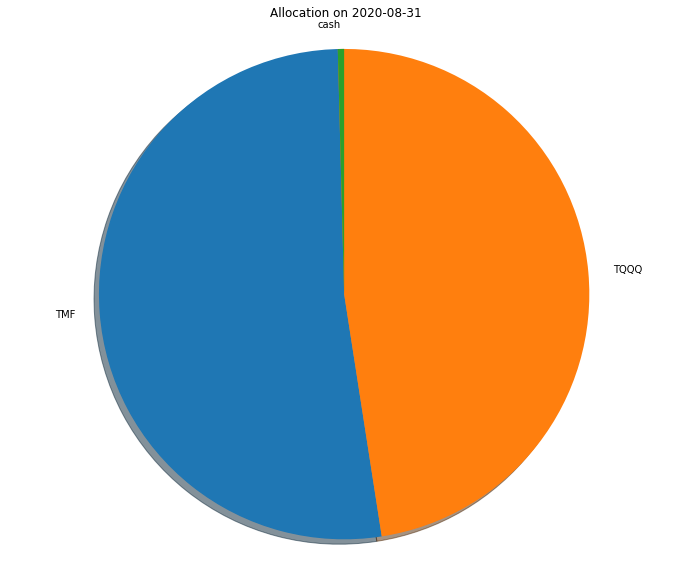

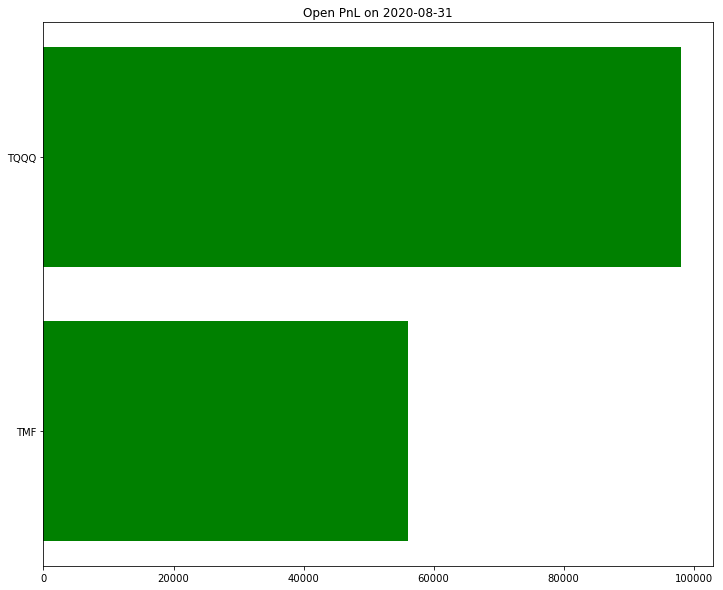

In [10]:
# Portfolio snapshot

# day to view
day = '2020-08-31'

# get portfolio value and positions for this day
port_value = result.loc[day, 'portfolio_value']
day_positions = result.loc[day, 'positions']

df = pd.DataFrame(columns = ['value', 'pnl'])
# populate with position info
for pos in day_positions:
    ticker = pos['sid'].symbol
    df.loc[ticker,'value'] = pos['amount'] * pos['last_sale_price']
    df.loc[ticker,'pnl'] = df.loc[ticker,'value'] - (pos['amount'] * pos['cost_basis'])
    
# cash position
df.loc['cash', ['value', 'pnl']] = [(port_value - df['value'].sum()), 0]

# pie chart for allocation
fig, ax1 = plt.subplots(figsize = [12, 10])
ax1.pie(df['value'], labels = df.index, shadow = True, startangle = 90)
ax1.axis('equal')
ax1.set_title('Allocation on {}'.format(day))
plt.show()

# bar chart for open PnL
fig, ax1 = plt.subplots(figsize = [12, 10])
pnl_df = df.drop('cash')
ax1.barh(pnl_df.index, pnl_df['pnl'], align = 'center', color = 'green', ecolor = 'black')
ax1.set_title('Open PnL on {}'.format(day))
plt.show()

In [11]:
# Portfolio Allocation of TMF and TQQQ
df1 = pd.DataFrame(index = result.index)
for day in result.index:
    port_value = result.loc[day, 'portfolio_value']
    positions = result.loc[day, 'positions']
    for pos in positions:
        ticker = pos['sid'].symbol
        df1.loc[day, ticker] = (pos['amount'] * pos['last_sale_price']) * 100 / port_value
        
print(df1.TMF.mean(), df1.TQQQ.mean())

55.78700133823651 44.26857820496889
